# Capstone Project

# Exploring Neighbourhoods in Toronto 
###### by Siddharaj Maramwar



Lets Install and import Required libraries

In [1]:
pip install BeautifulSoup4

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
from bs4 import BeautifulSoup  # Web Crawler
import requests # used to make requests from web
import pandas as pd
import lxml
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import lxml

In [5]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text

In [6]:
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')

In [7]:
#our dataframe will have three columns "PostalCode, Borough, and Neighborhood"
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)
df

,Postalcode,Borough,Neighborhood


In [8]:
for tr in table.find_all('tr'):
    row_data=[]
    for td_cell in tr.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [9]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Cleaning of our data frame

If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
And drop the rows where borough itself is Not assigned.

In [10]:
# Simply get the rows which has Borough
df=df[df['Borough']!='Not assigned']

Check if a value exists in a Borough column

In [11]:
exists = 'Not assigned' in df['Borough']
exists

False

Hence there in no cell in column 'Borough' having value => Not Assigned.

Now if a cell has a Not assigned in neighborhood column then use value of 'Borough'.

In [12]:
df[df['Neighborhood']=='Not assigned']=df['Borough'].reset_index()
df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:2957: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer(indexer, value)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [13]:
temp_df=df.groupby('Postalcode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)

In [14]:
df_merge = pd.merge(df, temp_df, on='Postalcode')
df_merge.drop(['Neighborhood'],axis=1,inplace=True)
df_merge.drop_duplicates(inplace=True)

In [15]:
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)
df_merge

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [16]:
df_merge.shape

(103, 3)

#### Part 2

Now we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

I was not able to get the geographical coordinates of the neighborhoods using the Geocoder package, so I used
csv file.


link -> http://cocl.us/Geospatial_data

In [17]:
cord_df=pd.read_csv('http://cocl.us/Geospatial_data')

In [18]:
cord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [21]:
cord_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
cord_merged = pd.merge(cord_df, df_merge, on='Postalcode')

In [22]:
geo_data=cord_merged[['Postalcode','Borough','Neighborhood','Latitude','Longitude']]

In [23]:
geo_data

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


We will work with boroughs that contain the word Toronto

In [32]:
toronto_data=geo_data[geo_data['Borough'].str.contains("Toronto")]
toronto_data = toronto_data.drop(['Postalcode'], axis = 1)


In [33]:
toronto_data

,Borough,Neighborhood,Latitude,Longitude
37,East Toronto,The Beaches,43.676357,-79.293031
41,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,East Toronto,Studio District,43.659526,-79.340923
44,Central Toronto,Lawrence Park,43.728020,-79.388790
45,Central Toronto,Davisville North,43.712751,-79.390197
46,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
47,Central Toronto,Davisville,43.704324,-79.388790
48,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [45]:
CLIENT_ID = 'BBB441WVOKMI1SPHXB4PTKZVFNGI10VUPHEIXUN2C11PRRJQ' #  Foursquare ID
CLIENT_SECRET = 'WY1BIGDADRVPBBG2YS13QARUXQIM4AR1B3KEUOIALD4500KN' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BBB441WVOKMI1SPHXB4PTKZVFNGI10VUPHEIXUN2C11PRRJQ
CLIENT_SECRET:WY1BIGDADRVPBBG2YS13QARUXQIM4AR1B3KEUOIALD4500KN


In [39]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### We will define a function for getting the venues

In [40]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
   
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### Define function to retieve ratings and likes of the venue

In [41]:
def get_venue_details(venue_id):
        
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

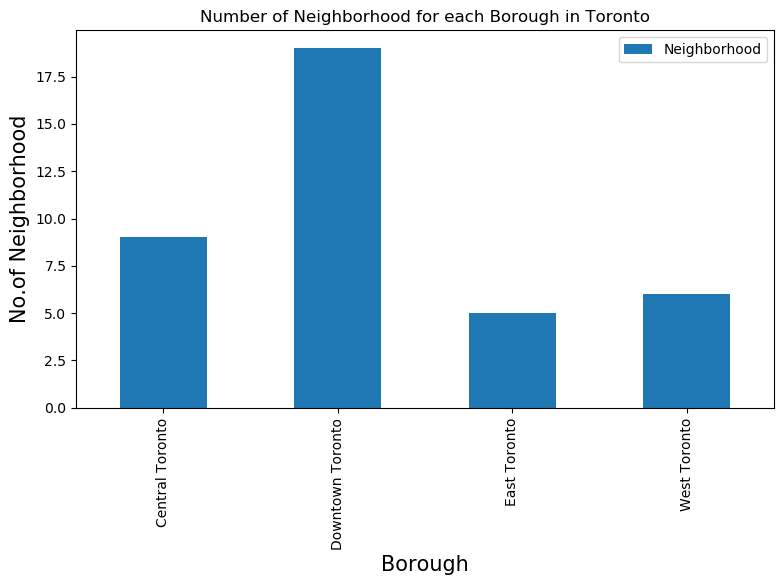

In [42]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
toronto_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [50]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_to=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(toronto_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_to = indian_rest_to.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 39 ) Indian Resturants in The Beaches, East Toronto:1
( 2 / 39 ) Indian Resturants in The Danforth West, Riverdale, East Toronto:1
( 3 / 39 ) Indian Resturants in India Bazaar, The Beaches West, East Toronto:9
( 4 / 39 ) Indian Resturants in Studio District, East Toronto:0
( 5 / 39 ) Indian Resturants in Lawrence Park, Central Toronto:0
( 6 / 39 ) Indian Resturants in Davisville North, Central Toronto:0
( 7 / 39 ) Indian Resturants in North Toronto West,  Lawrence Park, Central Toronto:0
( 8 / 39 ) Indian Resturants in Davisville, Central Toronto:3
( 9 / 39 ) Indian Resturants in Moore Park, Summerhill East, Central Toronto:0
( 10 / 39 ) Indian Resturants in Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park, Central Toronto:0
( 11 / 39 ) Indian Resturants in Rosedale, Downtown Toronto:0
( 12 / 39 ) Indian Resturants in St. James Town, Cabbagetown, Downtown Toronto:1
( 13 / 39 ) Indian Resturants in Church and Wellesley, Downtown Toronto:1
( 14 / 39 ) Indian Restur

Now we got all the indian restaurants in the Toronto City

In [56]:
indian_rest_to.head()

,Borough,Neighborhood,ID,Name
0,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro
1,East Toronto,"The Danforth West, Riverdale",4c1d5337eac020a1cb1048c2,Sher-E-Punjab
2,East Toronto,"India Bazaar, The Beaches West",4ae0c7a8f964a520638221e3,Udupi Palace
3,East Toronto,"India Bazaar, The Beaches West",4afc9816f964a520312422e3,Motimahal
4,East Toronto,"India Bazaar, The Beaches West",4bac30a2f964a52018ea3ae3,Bombay Chowpatty


In [57]:
indian_rest_to.shape

(27, 4)

We got 27 Indian Resturants across Toronto City

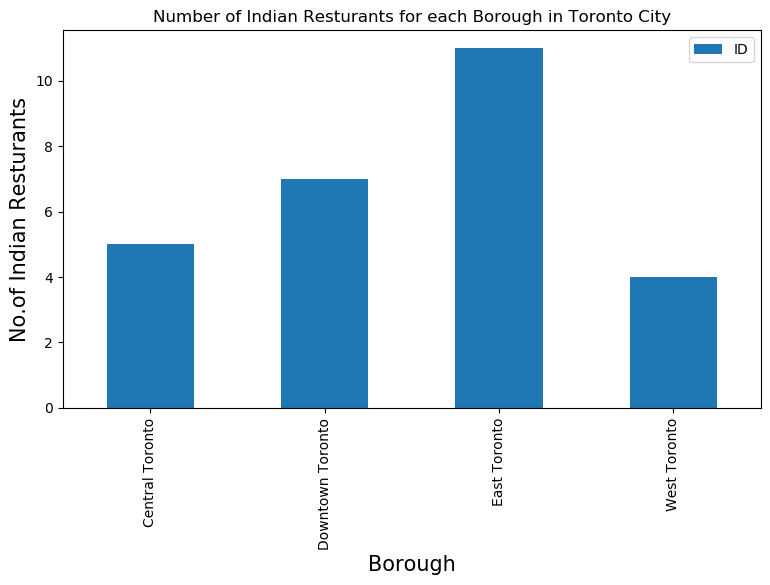

In [58]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_to.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that East Toronto has the largest number of indian resturants

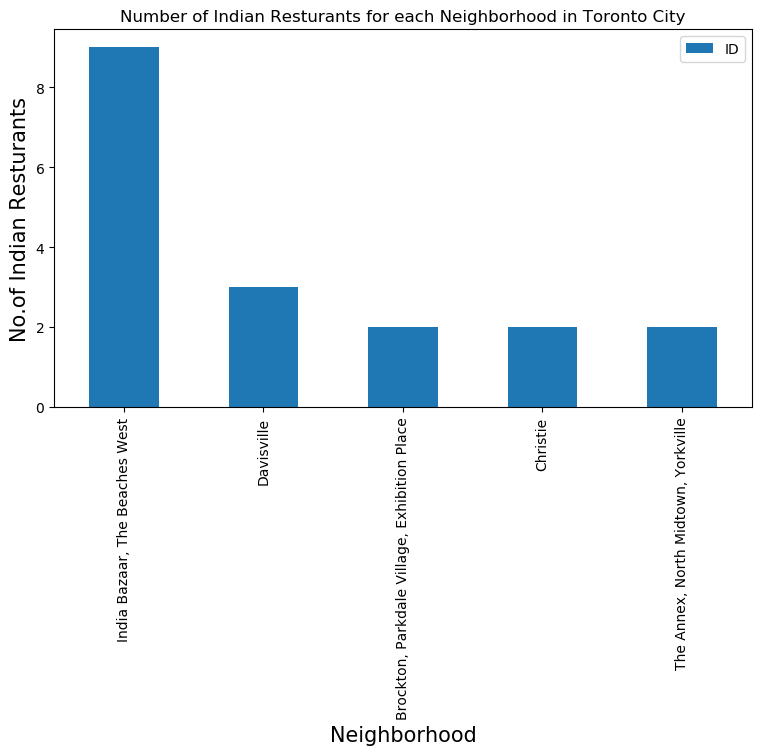

In [59]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in Toronto City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_to.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From Above we can observe the Neighborhood named "India Bazar" and "The Beaches West" has most number of 
Indian Restaurants.
If you look in the Postal Code dataframe (df)  you will see both Neighborhood has same postal code i.e,  M4L

From above we can tell the postal code with M4L has the maximum number of Indian Restaurants.

Now we will get the ranking of each resturant for further analysis.

In [65]:
#prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_to=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_to.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_to),')','processed')
    indian_rest_stats_to = indian_rest_stats_to.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID          Name  Likes  Rating  Tips
0  4dcd7c6352b1f8915b7e7f7e  Delhi Bistro      6     6.9     3
( 1 / 27 ) processed
                         ID           Name  Likes  Rating  Tips
0  4c1d5337eac020a1cb1048c2  Sher-E-Punjab     10     7.0     8
( 2 / 27 ) processed
                         ID          Name  Likes  Rating  Tips
0  4ae0c7a8f964a520638221e3  Udupi Palace     79     8.7    31
( 3 / 27 ) processed
                         ID       Name  Likes  Rating  Tips
0  4afc9816f964a520312422e3  Motimahal     25     8.1    13
( 4 / 27 ) processed
                         ID              Name  Likes  Rating  Tips
0  4bac30a2f964a52018ea3ae3  Bombay Chowpatty      7     7.1     5
( 5 / 27 ) processed
                         ID                Name  Likes  Rating  Tips
0  4ad9052cf964a520301721e3  Regency Restaurant      6     6.2     4
( 6 / 27 ) processed
                         ID         Name  Likes  Rating  Tips
0  4bbcc0efa0a0c9b60ebd1a0f  Haandi 2000

In [66]:
indian_rest_stats_to.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.9,3
1,East Toronto,"The Danforth West, Riverdale",4c1d5337eac020a1cb1048c2,Sher-E-Punjab,10,7.0,8
2,East Toronto,"India Bazaar, The Beaches West",4ae0c7a8f964a520638221e3,Udupi Palace,79,8.7,31
3,East Toronto,"India Bazaar, The Beaches West",4afc9816f964a520312422e3,Motimahal,25,8.1,13
4,East Toronto,"India Bazaar, The Beaches West",4bac30a2f964a52018ea3ae3,Bombay Chowpatty,7,7.1,5


Hurray!!
Now I fetched the Likes , Ratings, and Tips(user reviews) of the Indian restaurants in the city.

In [67]:
indian_rest_stats_to.shape

(27, 7)

In [69]:
indian_rest_to.shape

(27, 4)

From above we can observe we have fetched all data required for all the Indian restaurants in the city

Lets save this in CSV form

In [72]:
indian_rest_stats_to.to_csv('indian_rest_stats_to.csv', index=False)

Let's verify the saves csv file

In [73]:
indian_rest_stats_to_csv=pd.read_csv('indian_rest_stats_to.csv')

In [74]:
indian_rest_stats_to_csv

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.9,3
1,East Toronto,"The Danforth West, Riverdale",4c1d5337eac020a1cb1048c2,Sher-E-Punjab,10,7.0,8
2,East Toronto,"India Bazaar, The Beaches West",4ae0c7a8f964a520638221e3,Udupi Palace,79,8.7,31
3,East Toronto,"India Bazaar, The Beaches West",4afc9816f964a520312422e3,Motimahal,25,8.1,13
4,East Toronto,"India Bazaar, The Beaches West",4bac30a2f964a52018ea3ae3,Bombay Chowpatty,7,7.1,5
5,East Toronto,"India Bazaar, The Beaches West",4ad9052cf964a520301721e3,Regency Restaurant,6,6.2,4
6,East Toronto,"India Bazaar, The Beaches West",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000,3,6.0,7
7,East Toronto,"India Bazaar, The Beaches West",4d8d278a1d06b1f712942a3b,Gautama,15,5.8,15
8,East Toronto,"India Bazaar, The Beaches West",0,0,0,0.0,0
9,East Toronto,"India Bazaar, The Beaches West",0,0,0,0.0,0


In [76]:
indian_rest_stats_to_csv.shape

(27, 7)

In [77]:
indian_rest_stats_to.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       27 non-null     object 
 1   Neighborhood  27 non-null     object 
 2   ID            27 non-null     object 
 3   Name          27 non-null     object 
 4   Likes         27 non-null     object 
 5   Rating        27 non-null     float64
 6   Tips          27 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.6+ KB


We see that values like Likes, Tips are string values. We need to convert them into float values for further analysis.

In [86]:
indian_rest_stats_to[['Likes','Tips']]=indian_rest_stats_to[['Likes','Tips']].astype('float64')

In [87]:
indian_rest_stats_to.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       27 non-null     object 
 1   Neighborhood  27 non-null     object 
 2   ID            27 non-null     object 
 3   Name          27 non-null     object 
 4   Likes         27 non-null     float64
 5   Rating        27 non-null     float64
 6   Tips          27 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.6+ KB


Now Likes, Rating, Tips are converted to float and can be used for further analysis.

Lets find out average rating of resturants in the particular Neighborhood

In [88]:
to_neighborhood_stats=indian_rest_stats_to.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
to_neighborhood_stats.columns=['Neighborhood','Average Rating']

Let's Sort them according to the Ratings they achieved

In [89]:
to_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
1,Christie,8.450000
4,"High Park, The Junction South",8.300000
10,"The Annex, North Midtown, Yorkville",8.250000
2,Church and Wellesley,8.000000
6,"Queen's Park, Ontario Provincial Government",8.000000
9,"St. James Town, Cabbagetown",8.000000
0,"Brockton, Parkdale Village, Exhibition Place",7.850000
13,"University of Toronto, Harbord",7.800000
3,Davisville,7.133333
8,"Runnymede, Swansea",7.000000


We see Neighborhood 'Christie' has Maximum Rating of 8.45

Similarly lets do it for Borough

In [91]:
to_borough_stats=indian_rest_stats_to.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
to_borough_stats.columns=['Borough','Average Rating']

In [93]:
#Sort them
to_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
1,Downtown Toronto,7.928571
3,West Toronto,7.750000
0,Central Toronto,7.580000
2,East Toronto,5.072727


Borough Downtown Toronto has the Max Ratings with 7.92

Lets visualize it.

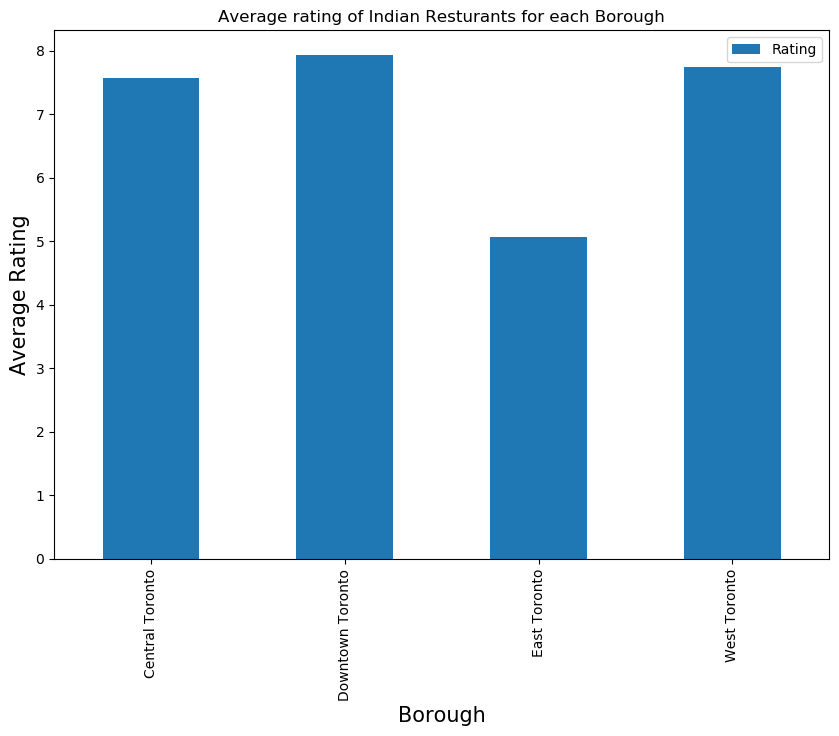

In [96]:
plt.figure(figsize=(10,7), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_to.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now we will consider all the neighborhoods with average rating greater or equal 6.0 to visualize on map

In [97]:
to_neighborhood_stats=to_neighborhood_stats[to_neighborhood_stats['Average Rating']>=6.0]

In [120]:

to_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,7.850000,"Brockton, Parkdale Village, Exhibition Place, ..."
1,Downtown Toronto,Christie,43.669542,-79.422564,8.450000,"Christie, Downtown Toronto(8.45)"
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.000000,"Church and Wellesley, Downtown Toronto(8.0)"
3,Central Toronto,Davisville,43.704324,-79.388790,7.133333,"Davisville, Central Toronto(7.133333333333333)"
4,West Toronto,"High Park, The Junction South",43.661608,-79.464763,8.300000,"High Park, The Junction South, West Toronto(8.3)"
5,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8.000000,"Queen's Park, Ontario Provincial Government, D..."
6,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,6.800000,"Regent Park, Harbourfront, Downtown Toronto(6.8)"
7,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,7.000000,"Runnymede, Swansea, West Toronto(7.0)"
8,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.000000,"St. James Town, Cabbagetown, Downtown Toronto(..."
9,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,8.250000,"The Annex, North Midtown, Yorkville, Central T..."


Now we will merge the toronto dataset to get Latitude and Longitude

In [99]:
to_neighborhood_stats=pd.merge(to_neighborhood_stats,toronto_data, on='Neighborhood')

In [100]:
to_neighborhood_stats=to_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [101]:
to_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,7.850000
1,Downtown Toronto,Christie,43.669542,-79.422564,8.450000
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.000000
3,Central Toronto,Davisville,43.704324,-79.388790,7.133333
4,West Toronto,"High Park, The Junction South",43.661608,-79.464763,8.300000
5,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8.000000
6,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,6.800000
7,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,7.000000
8,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.000000
9,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,8.250000


Now above we have the restaurants which has ratings grater or equal to 6.0 and their Geo-Co-ordinates

Lets Visualise it!

In [109]:
to_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

In [110]:
to_map

In [111]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in to_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [112]:
to_neighborhood_stats['Label']=to_neighborhood_stats['Neighborhood']+', '+to_neighborhood_stats['Borough']+'('+to_neighborhood_stats['Average Rating'].map(str)+')'

In [113]:
# add pop-up text to each marker on the map
for lat, lng, label in to_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(to_map)        
# add incidents to map
to_map.add_child(incidents)

In [ ]:
to_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)
to_geo = r'https://github.com/jasonicarter/toronto-geojson/blob/master/toronto_crs84.geojson'

to_map.choropleth(
    geo_data=to_geo,
    data=to_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

In [121]:
to_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
1,Downtown Toronto,Christie,43.669542,-79.422564,8.450000,"Christie, Downtown Toronto(8.45)"
4,West Toronto,"High Park, The Junction South",43.661608,-79.464763,8.300000,"High Park, The Junction South, West Toronto(8.3)"
9,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,8.250000,"The Annex, North Midtown, Yorkville, Central T..."
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.000000,"Church and Wellesley, Downtown Toronto(8.0)"
5,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8.000000,"Queen's Park, Ontario Provincial Government, D..."
8,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.000000,"St. James Town, Cabbagetown, Downtown Toronto(..."
0,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,7.850000,"Brockton, Parkdale Village, Exhibition Place, ..."
12,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,7.800000,"University of Toronto, Harbord, Downtown Toron..."
3,Central Toronto,Davisville,43.704324,-79.388790,7.133333,"Davisville, Central Toronto(7.133333333333333)"
7,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,7.000000,"Runnymede, Swansea, West Toronto(7.0)"


## Conclusion

#### Below are the Best Neighborhoods to open an Indian Restaurant

Christie,High Park,The Junction South, The Annex, North Midtown, Yorkville, Church and Wellesley, Queen's Park, Ontario Provincial Government, St. James Town, Cabbagetown

### Limitations 

1. The Results are highly dependent on the ratings of the Restaurants.
2. The Rating Accuracy is highly dependent on Foursquare API.